In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"
from sparse_causal_model_learner_rl.keychest_vae.data import learner, h, w, c, engine, plot_data, get_dataloader, obss_to_rgb, get_xy_conv
from sparse_causal_model_learner_rl.keychest_vae.vae import ObsNet, ObsModel
import gin
import numpy as np
from matplotlib import pyplot as plt
import torchvision
from torch.autograd import Variable
from tqdm.auto import tqdm
from causal_util.helpers import lstdct2dctlst
%matplotlib inline

Make environment KeyChest-v0 None {}


In [2]:
learner, engine, (h, w, c)

(<Learner env=<KeyChestGymEnv<KeyChest-v0>> feature_shape=(30,) epochs=0>,
 (12, 7, 11))

In [6]:
gin.bind_parameter('rgb_resize.active', True)

In [7]:
train_loader = get_dataloader(20)
eval_loader = get_dataloader(20)

Make environment KeyChest-v0 None {}



3.0
3.0
Make environment KeyChest-v0 None {}



3.0
3.0


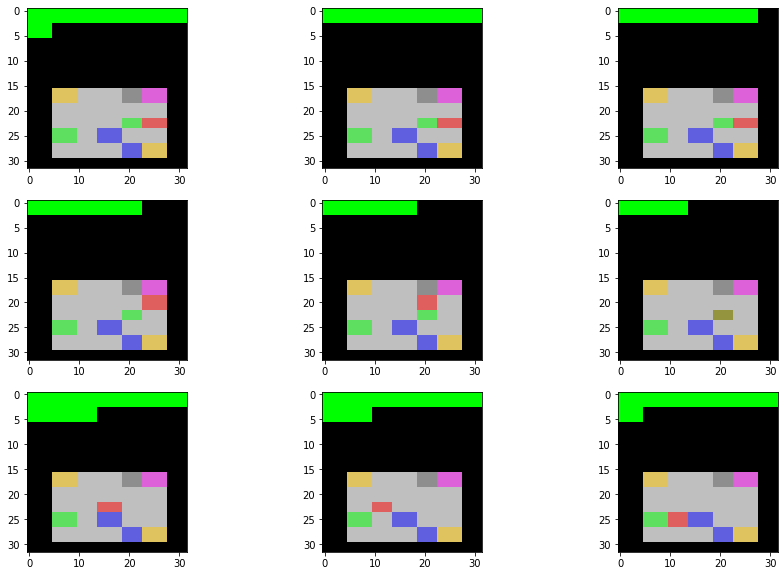

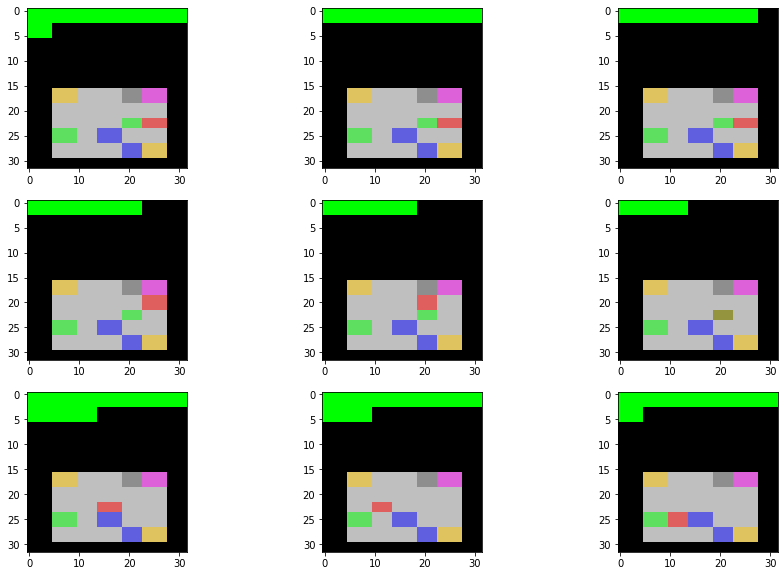

In [8]:
plot_data(np.rollaxis(train_loader.dataset.tensors[0].numpy(), 1, 4), gx=3, gy=3)

In [17]:
# gin.bind_parameter('ObsNet.kernel_sizes', [3, 3, 2])
# gin.bind_parameter('ObsNet.strides', [1, 1, 1])
# gin.bind_parameter('ObsNet.channels', [3, 32, 32])

# gin.bind_parameter('ObsNet.paddings', [0, 0, 1])
# gin.bind_parameter('ObsNet.last_conv', False)
# gin.bind_parameter('ObsNet.add_gan', False)


gin.bind_parameter('ObsNet.hid_x', 16)
gin.bind_parameter('ObsNet.hid_y', 16)

In [18]:
img = train_loader.dataset.tensors[0][0:1]#.cuda()

In [19]:
m = ObsModel(train_loader, eval_loader)
train_losses = []

In [20]:
#m.model.apply_gan(img)

In [21]:
[x.shape for x in m.model.apply_conv(img)], [x.shape for x in m.model.apply_deconv(m.model.apply_conv(img)[-1])]

([torch.Size([1, 3, 32, 32]),
  torch.Size([1, 3, 32, 32]),
  torch.Size([1, 32, 16, 16]),
  torch.Size([1, 32, 16, 16]),
  torch.Size([1, 32, 16, 16])],
 [torch.Size([1, 32, 16, 16]),
  torch.Size([1, 32, 16, 16]),
  torch.Size([1, 32, 16, 16]),
  torch.Size([1, 3, 32, 32]),
  torch.Size([1, 3, 32, 32])])

In [22]:
np.mean((train_loader.dataset.tensors[0] - train_loader.dataset.tensors[2]).numpy())

0.001022997

In [23]:
for _ in tqdm(range(20000)):
    train_losses.append(m.train())

/home/serge/miniconda3/envs/causal/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


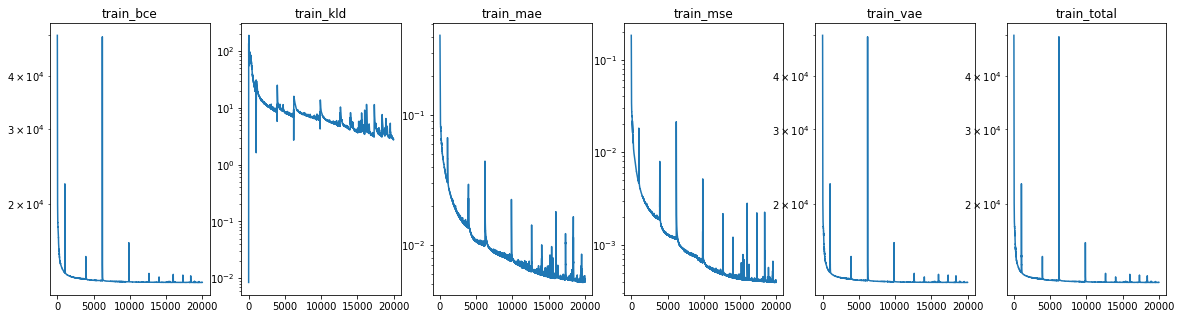

In [24]:
vis = lstdct2dctlst(train_losses)
plt.figure(figsize=(20, 5))
for i, (key, arr) in enumerate(vis.items()):
    plt.subplot(1, len(vis), i + 1)
    plt.title(key)
    plt.plot(arr)
    plt.yscale('log')
plt.show()

In [25]:
m.model.encode(img)

(tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.7735, 0.7645, 0.0000,
          0.0000, 0.0000, 0.6688, 1.0658, 0.0000, 0.0000, 0.0000, 0.8278, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.0027, 3.5594, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0985, 0.0000, 0.0000, 0.0000,
          0.2576, 0.0000, 0.5856, 0.0000, 0.0000, 0.0000, 0.0231, 0.5348, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.9939, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 2.5397, 0.0000, 0.0000, 0.1140, 0.2744, 0.0000, 0.0000, 0.0000,
          0.5759, 0.5394, 0.0000, 0.0000, 0.0000, 0.0000, 0.4361, 0.0000, 0.0000,
          0.0000, 0.3637, 0.9213, 0.0000, 0.0000, 0.0000, 1.0618, 0.0000, 0.0000,
          0.0000, 0.0000, 0.1515, 0.0000, 2.9635, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000

In [26]:
m.eval()

{'eval_bce': 37202.78515625,
 'eval_kld': 2.344783306121826,
 'eval_mae': 0.047707587480545044,
 'eval_mse': 0.02113528363406658,
 'eval_vae': 37205.12890625,
 'eval_total': 37205.12890625}

In [27]:
# mnist = torchvision.datasets.MNIST("./mnist", train=True, download=True, transform=transforms.Compose([
#                                                               transforms.ToTensor(), # first, convert image to PyTorch tensor
#                                                           ]))
# action_dummy = TensorDataset(torch.zeros((len(mnist), 4)))
# mnist_loader = DataLoader(mnist, batch_size=512, shuffle=True)

# gin.bind_parameter('ObsNet.input_channels', 1)
# gin.bind_parameter('ObsNet.hid_x', 14)
# gin.bind_parameter('ObsNet.hid_y', 14)

# m = ObsModel(mnist_loader)

In [32]:
def get_images(m, loader):
    m.model.eval()
    _, (states, actions, next_states) = next(enumerate(loader))
    states = Variable(states).to(m.device)
    actions = Variable(actions).to(m.device)
    next_states = Variable(next_states).to(m.device)

    # mnist
    # states = next(enumerate(m.train_loader))[1][0].cuda()
    # actions = torch.zeros((states.shape[0], 4)).cuda()
    # next_states = states
    
    out, _, _ = m.model(states, actions)
    out = np.rollaxis(out.detach().cpu().numpy(), 1, 4)
    return out

In [33]:
train_images = get_images(m, train_loader)
eval_images = get_images(m, eval_loader)
demo_images = np.rollaxis(train_loader.dataset.tensors[0].numpy(), 1, 4)

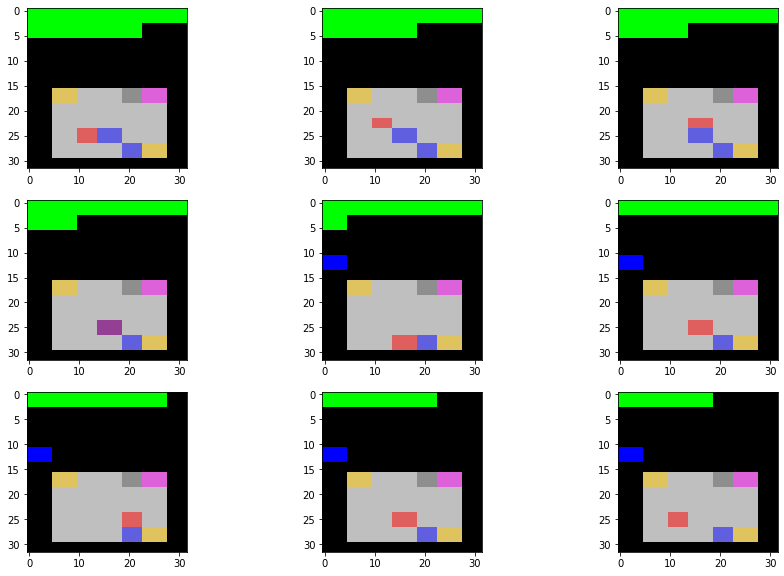

In [34]:
_ = plot_data(demo_images, gy=3)

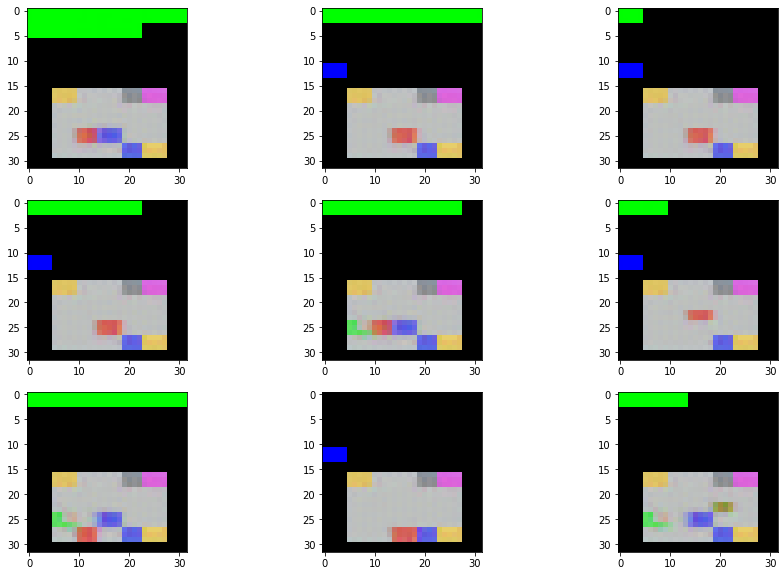

In [35]:
_ = plot_data(train_images, gy=3)

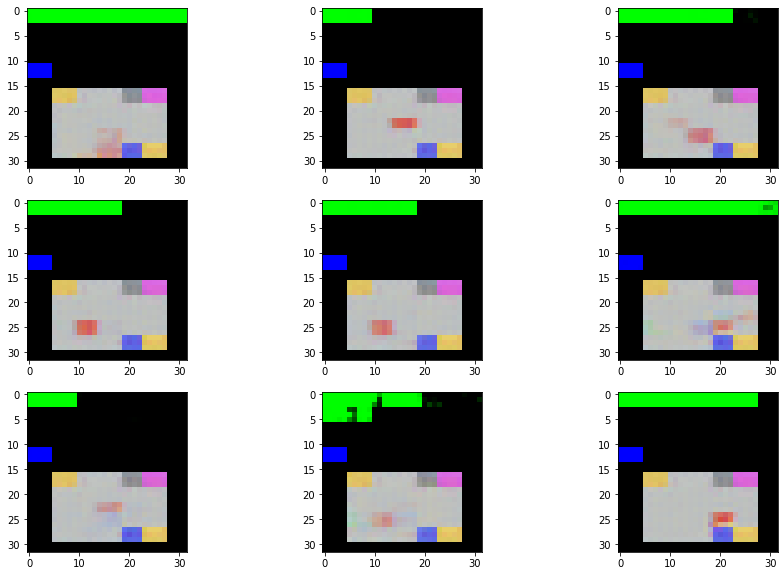

In [36]:
_ = plot_data(eval_images, gy=3)

In [37]:
train_image_idx = np.random.choice(range(len(train_images)))
eval_image_idx = np.random.choice(range(len(eval_images)))
demo_image_idx = np.random.choice(range(len(demo_images)))


train_image = train_images[train_image_idx]
eval_image = eval_images[eval_image_idx]
demo_image = demo_images[demo_image_idx]

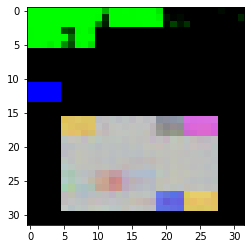

In [38]:
plt.imshow(eval_image)

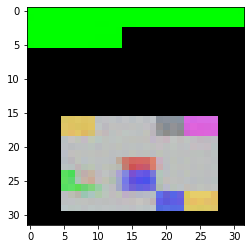

In [39]:
plt.imshow(train_image)

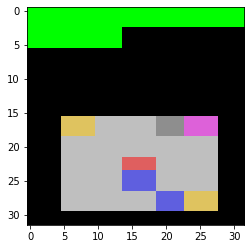

In [40]:
plt.imshow(demo_image)